<a href="https://colab.research.google.com/github/eddie000000/EfficientDetYZU/blob/master/gan_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 匯入需要的套件和 MNIST 資料集 ##
''' mnist練習用
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from IPython.core.debugger import Tracer
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
'''

In [ ]:
''' mnist練習用
class Gan(object):
  def __init__(self, width=512, height=512, channels=3):
    self.width=width
    self.height=height
    self.channels=channels

    self.shape = (self.width, self.height, self.channels)
    self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
    self.G = self.__generator()
    self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

    self.D = self.__discriminator()
    self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

    self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

    self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

  def __generator(self):
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))  # 使用 LeakyReLU 激活函數
    model.add(BatchNormalization(momentum=0.8))  # 使用 BatchNormalization 優化
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
    model.add(Reshape((self.width, self.height, self.channels)))
    model.summary()

    return model

  def __discriminator(self):

    model = Sequential()
    model.add(Flatten(input_shape=self.shape))
    model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(int((self.width * self.height * self.channels)/2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model
  
  def __stacked_generator_discriminator(self):

    self.D.trainable = False
    model = Sequential()
    model.add(self.G)
    model.add(self.D)

    return model

  def train(self, X_train, epochs=1000, batch = 32, save_interval = 100):
    for cnt in range(epochs):
        ## train discriminator
        random_index = np.random.randint(0, len(X_train) - batch/2)
        legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), self.width, self.height, self.channels)

        gen_noise = np.random.normal(0, 1, (int(batch/2), 100)) 
        syntetic_images = self.G.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))
        y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))

        d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


        # train generator

        noise = np.random.normal(0, 1, (batch, 100))  # 添加高斯噪聲
        y_mislabled = np.ones((batch, 1))

        g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

        print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

        if cnt % save_interval == 0:
            self.plot_images(save2file=True, step=cnt)

  def plot_images(self, save2file=False, samples=16, step=0):
    filename = "/content/drive/My Drive/gan/mnist_%d.png" % step
    noise = np.random.normal(0, 1, (samples, 100))

    images = self.G.predict(noise)

    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [self.height, self.width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp "/content/drive/My Drive/AIdata2/train_images.zip" /content/

In [ ]:
! unzip /content/train_images.zip > data_unzip.log

In [ ]:
! cp "/content/drive/My Drive/AIdata2/test_images.zip" /content/

cp: cannot stat '/content/drive/My Drive/AIdata2/test_images.zip': No such file or directory


In [ ]:
! unzip /content/test_images.zip > data2_unzip.log

unzip:  cannot find or open /content/test_images.zip, /content/test_images.zip.zip or /content/test_images.zip.ZIP.


參考網址
https://colab.research.google.com/drive/1JYY_HHtVSSOLixZfLwkxiWTRdPHJCS2t

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class data_deal(Dataset):
  def __init__(self, fnames, transform):
    self.transform = transform
    self.fnames = fnames
    self.num_samples = len(self.fnames)
  def __getitem__(self, idx):
    fname = self.fnames[idx]
    img = cv2.imread(fname)
    img = self.BGR2RGB(img) #because "torchvision.utils.save_image" use RGB
    img = self.transform(img)
    return img

  def __len__(self):
    return self.num_samples
  def BGR2RGB(self, img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

import glob
import torchvision.transforms as transforms

def get_dataset(root):
  fnames = glob.glob(os.path.join(root, '*'))
  transform = transforms.Compose(
      [transforms.ToPILImage(),
       transforms.Resize((256, 256)),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)] )
  dataset = data_deal(fnames, transform)
  return dataset

In [ ]:
import random
import torch
import numpy as np

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
class Generator(nn.Module):
    def __init__(self, in_dim, dim=64):
      super(Generator, self).__init__()
      self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_dim, dim * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(dim * 32),
            nn.ReLU(True),
            # state size. (dim*32) x 4 x 4
            nn.ConvTranspose2d(dim * 32, dim * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 16),
            nn.ReLU(True),
            # state size. (dim*16) x 8 x 8
            nn.ConvTranspose2d(dim * 16, dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 8),
            nn.ReLU(True),
            # state size. (dim*8) x 16 x 16
            nn.ConvTranspose2d(dim * 8, dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.ReLU(True),
            # state size. (dim*4) x 32 x 32
            nn.ConvTranspose2d(dim * 4, dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.ReLU(True),
            # state size. (dim*2) x 64 x 64
            nn.ConvTranspose2d(dim * 2, dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            # state size. (dim) x 128 x 128
            nn.ConvTranspose2d(dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )
      #self.apply(weights_init)
    def forward(self, x):
        '''
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)'''
        y = self.main(x)
        return y

class Discriminator(nn.Module):
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(in_dim, dim, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim) x 128 x 128

            nn.Conv2d(dim, dim * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim*2) x 64 x 64

            nn.Conv2d(dim * 2, dim * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim*4) x 32 x 32

            nn.Conv2d(dim * 4, dim * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim*8) x 16 x 16

            nn.Conv2d(dim * 8, dim * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim*16) x 8 x 8

            nn.Conv2d(dim * 16, dim * 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dim*32) x 4 x 4

            nn.Conv2d(dim * 32, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )      
        #self.apply(weights_init)  
    def forward(self, x):
        y = self.main(x)
        return y

In [ ]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision
workspace_dir = '/content/drive/My Drive/gan/'
# hyperparameters 
batch_size = 64
z_dim = 100
lr = 1e-4
n_epoch = 1118
save_dir = os.path.join(workspace_dir, 'logs4')
os.makedirs(save_dir, exist_ok=True)

# model
G = Generator(z_dim).cuda()
D = Discriminator(in_dim=3).cuda()
G.train()
D.train()

# loss criterion
criterion = nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


same_seeds(0)
# dataloader (You might need to edit the dataset path if you use extra dataset.)
dataset = get_dataset(os.path.join(workspace_dir, '/content/train_images/train/4/'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


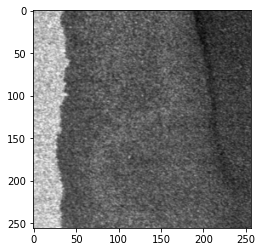

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dataset[10].numpy().transpose(1,2,0))


In [ ]:
z_sample = Variable(torch.randn(100, z_dim,1,1)).cuda()

for e, epoch in enumerate(range(n_epoch)):
    for i, data in enumerate(dataloader):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        """ Train D """
        z = Variable(torch.randn(bs, z_dim,1,1)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        # label        
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # dis
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # compute loss
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # update model
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        """ train G """
        # leaf
        z = Variable(torch.randn(bs, z_dim,1,1)).cuda()
        f_imgs = G(z)

        # dis
        f_logit = D(f_imgs)
        
        # compute loss
        loss_G = criterion(f_logit, r_label)

        # update model
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{n_epoch}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(save_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    # show generated image
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()
    if (e+1) % 5 == 0:
        torch.save(G.state_dict(), os.path.join(workspace_dir, f'dcgan_g4.pth'))
        torch.save(D.state_dict(), os.path.join(workspace_dir, f'dcgan_d4.pth'))


In [ ]:
import torch
# load pretrained model
G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(workspace_dir, 'dcgan_g4.pth')))
G.eval()
G.cuda()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [ ]:
''' 輸出一張測試
n_output = 1
z_sample = Variable(torch.randn(n_output, 100,1,1)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
nn = 'result'+str(i+1)+'.jpg'
save_dir = os.path.join(workspace_dir, 'logs1')
filename = os.path.join(save_dir, nn)
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
'''

" 輸出一張測試\nn_output = 1\nz_sample = Variable(torch.randn(n_output, 100,1,1)).cuda()\nimgs_sample = (G(z_sample).data + 1) / 2.0\nnn = 'result'+str(i+1)+'.jpg'\nsave_dir = os.path.join(workspace_dir, 'logs1')\nfilename = os.path.join(save_dir, nn)\ntorchvision.utils.save_image(imgs_sample, filename, nrow=10)\n\ngrid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)\nplt.figure(figsize=(10,10))\nplt.imshow(grid_img.permute(1, 2, 0))\nplt.show()\n"

In [ ]:
for i in range(500):
  n_output = 1
  z_sample = Variable(torch.randn(n_output, 100,1,1)).cuda()
  imgs_sample = (G(z_sample).data + 1) / 2.0
  nn = 'result'+str(i+1)+'.jpg'
  save_dir = os.path.join(workspace_dir, '4')
  filename = os.path.join(save_dir, nn)
  torchvision.utils.save_image(imgs_sample, filename, nrow=10)

  grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
  plt.figure(figsize=(10,10))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()
